# NSSP project 1

In this notebook, we aims to study the neural processing of emotionally provocative auditory stimuli.

### Import, setup FSL

In [1]:
%gui wx
import sys
import os
import os.path as op

#utility functions from previous labs
import utils 

#to download the dataset from openneuro
import subprocess
import openneuro

#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt
from fsl.wrappers import mcflirt

from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

#concatenation
from nilearn.image import concat_imgs, mean_img
import nibabel as nib

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json
import subprocess
####################
# Setup FSL path
####################
utils.loadFSL()

In [2]:
################
# Start FSLeyes (very neat tool to visualize MRI data of all sorts) within Python
################
fsleyesDisplay = utils.FSLeyesServer()
fsleyesDisplay.show()

16:46:17: Debug: Adding duplicate image handler for 'Windows bitmap file'
16:46:17: Debug: Adding duplicate animation handler for '1' type
16:46:17: Debug: Adding duplicate animation handler for '2' type
16:46:17: Debug: Adding duplicate image handler for 'Windows bitmap file'
16:46:17: Debug: Adding duplicate animation handler for '1' type
16:46:17: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:8241): Gtk-CRITICAL **: 16:46:17.819: gtk_window_resize: assertion 'height > 0' failed


In [3]:
#We define the parameters RERUN to rerun all the transform, if false it will use the saved files.
RERUN = False 

### Download and explore the dataset

In [4]:
#download the dataset

#"https://openneuro.org/datasets/ds000171/versions/00001"
dataset= 'ds000171'
version = '00001'
subject = 'sub-control01'
subjectID = 'control01'

#path to save
sample_path = "dataset"
utils.mkdir_no_exist(sample_path)

# Construct paths
bids_root = os.path.join(os.path.abspath(""), sample_path, dataset)
deriv_root = os.path.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

#folder for derivative and preprocess
utils.mkdir_no_exist(deriv_root)
utils.mkdir_no_exist(preproc_root)
utils.mkdir_no_exist(op.join(preproc_root, subject))
utils.mkdir_no_exist(op.join(preproc_root, subject, 'anat'))
utils.mkdir_no_exist(op.join(preproc_root, subject, 'func'))
utils.mkdir_no_exist(op.join(preproc_root, subject, 'fmap'))

#run this line only if you dont have the dataset 
#subprocess.run(["openneuro-py", "download", "--dataset", dataset, "--target_dir", bids_root,"--include",subject], check=True)

In [5]:
# explore the dataset folder
print_dir_tree(bids_root,4)

|ds000171/
|--- CHANGES
|--- README
|--- T1w.json
|--- dataset_description.json
|--- participants.tsv
|--- task-music_bold.json
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|------------ fmap/
|------------ func/
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv
|--------- sub-control01_task-nonmusic_run-4_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-4_events.tsv
|--------- sub-control01_task-nonmusic_run-5_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-5_events.tsv
|--------- .ipynb_checkpoints/
|------------ sub-control01_task-music_run-2_events-checkpoint.tsv


In [6]:
data_description = utils.get_json_from_file(op.join(bids_root,'dataset_description.json'))
data_description

data_task = utils.get_json_from_file(op.join(bids_root,'task-music_bold.json'))
data_task

{'TaskName': 'Music',
 'RepetitionTime': 3.0,
 'EchoTime': 0.025,
 'FlipAngle': 90.0,
 'SequenceName': 'EPI BOLD',
 'Manufacturer': 'Siemens',
 'ManufacturersModelName': 'Skyra',
 'MagneticFieldStrength': 3.0,
 'ParallelImagingReductionFactor': 0,
 'SliceTimingComputationMethod': '(slicenum*RepetitionTime/TotalSlices), interleaved according to Siemens even-numbered slice convention (even slices first).',
 'SliceTiming': [1.5,
  0.0,
  1.56,
  0.06,
  1.62,
  0.12,
  1.68,
  0.18,
  1.74,
  0.24,
  1.8,
  0.3,
  1.86,
  0.36,
  1.92,
  0.42,
  1.98,
  0.48,
  2.04,
  0.54,
  2.1,
  0.6,
  2.16,
  0.66,
  2.22,
  0.72,
  2.28,
  0.78,
  2.34,
  0.84,
  2.4,
  0.9,
  2.46,
  0.96,
  2.52,
  1.02,
  2.58,
  1.08,
  2.64,
  1.14,
  2.7,
  1.2,
  2.76,
  1.26,
  2.82,
  1.32,
  2.88,
  1.38,
  2.94,
  1.44]}

In [7]:
# explore anatomical
#fsleyesDisplay.resetOverlays()
#fsleyesDisplay.load(op.join(bids_root, subject,'anat','sub-control01_T1w.nii.gz'))

# explore one functional 
#fsleyesDisplay.resetOverlays()
#fsleyesDisplay.load(op.join(bids_root, subject,'func','sub-control01_task-music_run-1_bold.nii.gz'))

## PART 1

### Pre-processing
Prior to analysis we need to pre process the data.
We will standardize each run of interest of sub-control01 and concatenate all together.<br/>
Then,we will apply standard preprocessing steps.

<b>Anatomical preprocessing</b>
1. Skull stripping
2. segmentation
3. Coregistration & Normalisation

<b>functional preprocessing</b>
1. standardisation
2. concatenation
3. motion correction
4. Coregistration & normalisation
5. smoothing

#### <b>Anatomical preprocessing</b>

In [8]:
#Skull stripping 
def get_skull_stripped_anatomical(bids_root, preproc_root, subject_id, robust=False):
    """
    Function to perform skull-stripping (removing the skull around the brain).
    This is a simple wrapper around the brain extraction tool (BET) in FSL's suite
    It assumes data to be in the BIDS format.
    The method also saves the brain mask which was used to extract the brain.

    The brain extraction is conducted only on the T1w of the participant.

    Parameters
    ----------
    bids_root: string
        The root of the BIDS directory
    preproc_root: string
        The root of the preprocessed data, where the result of the brain extraction will be saved.
    subject_id: string
        Subject ID, the subject on which brain extraction should be conducted.
    robust: bool
        Whether to conduct robust center estimation with BET or not. Default is False.
    """
    # We perform here skull stripping
    subject = 'sub-{}'.format(subject_id)
    anatomical_path = op.join(bids_root, subject, 'anat', 'sub-{}_T1w.nii.gz'.format(subject_id))
    betted_brain_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w'.format(subject_id))
    
    os.system('bet {} {} -m {}'.format(anatomical_path, betted_brain_path, '-R' if robust else ''))
    print("Done with BET.")

resulting_mask_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w_mask'.format(subjectID))

if RERUN :
    get_skull_stripped_anatomical(bids_root, preproc_root, subjectID,robust=True)

In [9]:
#display the mask and observe that the skull is correctely removed
#fsleyesDisplay.load(resulting_mask_path)

After verification and manual corrections, we consider the skull tripping mask good enough. We apply the mask.

In [10]:
def apply_fsl_math_approach(img_path, mask_path, masked_img_path):
    """
    Apply a mask
    """
    os.system('fslmaths {} -mas {} {}'.format(img_path, mask_path, masked_img_path))
    

anatomical_path = op.join(bids_root, subject, 'anat', 'sub-{}_T1w'.format(subjectID)) # The original brain
betted_brain_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w'.format(subjectID)) # The brain without skull is in the derivatives folder
resulting_mask_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w_mask_handmodif'.format(subjectID)) # The mask to use

if RERUN :
    apply_fsl_math_approach(anatomical_path, resulting_mask_path, betted_brain_path)

In [11]:
#display the brain without the skull
#fsleyesDisplay.load(betted_brain_path)

In [12]:
#segmentation
segmentation_path = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w_fast'.format(subjectID))
if RERUN : 
    [os.remove(f) for f in glob.glob(op.join(preproc_root, subject, 'anat', '*fast*'))] # Just to clean the directory in between runs of the cell
    fast(imgs=[betted_brain_path], out=segmentation_path, n_classes=3)

In [13]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- T1w.json
|--- dataset_description.json
|--- participants.tsv
|--- task-music_bold.json
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|--------------- sub-control01_T1w.nii.gz
|--------------- sub-control01_T1w_fast_mixeltype.nii.gz
|--------------- sub-control01_T1w_fast_pve_0.nii.gz
|--------------- sub-control01_T1w_fast_pve_1.nii.gz
|--------------- sub-control01_T1w_fast_pve_2.nii.gz
|--------------- sub-control01_T1w_fast_pveseg.nii.gz
|--------------- sub-control01_T1w_fast_seg.nii.gz
|--------------- sub-control01_T1w_mask.nii.gz
|--------------- sub-control01_T1w_mask_handmodif.nii.gz
|--------------- sub-control01_T1w_mni.nii.gz
|------------ fmap/
|------------ func/
|--------------- sub-control01_all_task_bold.nii
|--------------- sub-control01_all_task_bold_bbr.mat
|--------------- sub-control01_all_task_bold_bbr.nii.gz
|--------------- sub-control01_all_task_bold_bbr_fast_wmedge.nii.gz
|-

In [14]:
#fsleyesDisplay.resetOverlays()
#fsleyesDisplay.load(betted_brain_path)
#fsleyesDisplay.load(glob.glob(op.join(preproc_root, subject, 'anat','*pve_0*'))[0])
#fsleyesDisplay.load(glob.glob(op.join(preproc_root, subject, 'anat','*pve_1*'))[0])
#fsleyesDisplay.load(glob.glob(op.join(preproc_root, subject, 'anat','*pve_2*'))[0])
#fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[1]).cmap = 'Red'
#fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[2]).cmap = 'Green'
#fsleyesDisplay.displayCtx.getOpts(fsleyesDisplay.overlayList[3]).cmap = 'Blue'

The segmentation correctely separated grey matter, white matter and cerebrospinal fluid.

In [15]:
#Coregistration

mni_template = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain'))

target = betted_brain_path
reference = mni_template
result = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w_mni'.format(subjectID))

if RERUN :
    flirt(target, reference, out=result)

#we may add a cost later
#j'ai perdu le cervelet, a refaire plus tard

In [16]:
#display the coregistred brain
#fsleyesDisplay.resetOverlays()
#fsleyesDisplay.load(reference) 
#fsleyesDisplay.load(result)

This step finish the anatomical preprocessing.

#### <b>functionnal preprocessing</b>

In [17]:
print_dir_tree(op.join(bids_root, subject, 'func')) #functionnal directory

|func/
|--- sub-control01_task-music_run-1_bold.nii.gz
|--- sub-control01_task-music_run-1_events.tsv
|--- sub-control01_task-music_run-2_bold.nii.gz
|--- sub-control01_task-music_run-2_events.tsv
|--- sub-control01_task-music_run-3_bold.nii.gz
|--- sub-control01_task-music_run-3_events.tsv
|--- sub-control01_task-nonmusic_run-4_bold.nii.gz
|--- sub-control01_task-nonmusic_run-4_events.tsv
|--- sub-control01_task-nonmusic_run-5_bold.nii.gz
|--- sub-control01_task-nonmusic_run-5_events.tsv
|--- .ipynb_checkpoints/
|------ sub-control01_task-music_run-2_events-checkpoint.tsv


In [18]:
import re

func_dir = op.join(bids_root, subject, 'func')
pattern = re.compile(r'^sub-control01_task-music_run-\d+_bold\.nii\.gz$')
file_paths = []

# Check if the directory exists
if os.path.exists(func_dir):
    for file_name in os.listdir(func_dir):
        # If the file name matches the pattern, add it to the array with the full path
        if pattern.match(file_name):
            full_path = os.path.join(func_dir, file_name)
            file_paths.append(full_path)
            mri = nib.load(full_path)
            print(mri.shape)


file_paths.sort()

# Output the array of all runs
print(len(file_paths))
print(file_paths)

(80, 80, 50, 105)
(80, 80, 50, 105)
(80, 80, 50, 105)
3
['/data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-1_bold.nii.gz', '/data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-2_bold.nii.gz', '/data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-3_bold.nii.gz']


In [19]:
#concatenation

concat_path = os.path.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold'.format(subjectID))

if RERUN :
    fmri_img = concat_imgs(file_paths)
    nib.save(fmri_img, concat_path)

In [20]:
#motion correction

path_moco_data = os.path.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold_moco'.format(subjectID))

if RERUN :
    mcflirt(infile=concat_path,o=path_moco_data, plots=True, report=True, dof=6, mats=True)


In [21]:
#fsleyesDisplay.resetOverlays()
#fsleyesDisplay.load(concat_path)
#fsleyesDisplay.load(path_moco_data)


(ipykernel_launcher.py:8241): GLib-GIO-CRITICAL **: 16:48:40.593: GFileInfo created without standard::is-hidden

(ipykernel_launcher.py:8241): GLib-GIO-CRITICAL **: 16:48:40.593: file ../gio/gfileinfo.c: line 1633 (g_file_info_get_is_hidden): should not be reached

(ipykernel_launcher.py:8241): GLib-GIO-CRITICAL **: 16:48:40.593: GFileInfo created without standard::is-backup

(ipykernel_launcher.py:8241): GLib-GIO-CRITICAL **: 16:48:40.593: file ../gio/gfileinfo.c: line 1655 (g_file_info_get_is_backup): should not be reached

(ipykernel_launcher.py:8241): GLib-GIO-CRITICAL **: 16:48:40.593: GFileInfo created without standard::is-hidden

(ipykernel_launcher.py:8241): GLib-GIO-CRITICAL **: 16:48:40.593: file ../gio/gfileinfo.c: line 1633 (g_file_info_get_is_hidden): should not be reached

(ipykernel_launcher.py:8241): GLib-GIO-CRITICAL **: 16:48:40.593: GFileInfo created without standard::is-backup

(ipykernel_launcher.py:8241): GLib-GIO-CRITICAL **: 16:48:40.593: file ../gio/gfileinfo.

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,-0.003259,0.002840,-0.000031,-0.051888,-0.515034,-0.484302
1,-0.003411,0.002840,-0.000225,-0.066839,-0.500594,-0.459029
2,-0.003315,0.002840,-0.000031,-0.049307,-0.473566,-0.447389
3,-0.003210,0.003142,-0.000388,-0.066097,-0.481195,-0.463564
4,-0.002620,0.002840,-0.000145,-0.066628,-0.472082,-0.495653
...,...,...,...,...,...,...
310,0.008883,0.000022,-0.002083,-0.098059,0.392837,0.241959
311,0.009054,0.000004,-0.002145,-0.079201,0.364524,0.228942
312,0.009254,-0.000309,-0.002069,-0.088202,0.395007,0.228906
313,0.009035,-0.000375,-0.002168,-0.097997,0.373078,0.213758


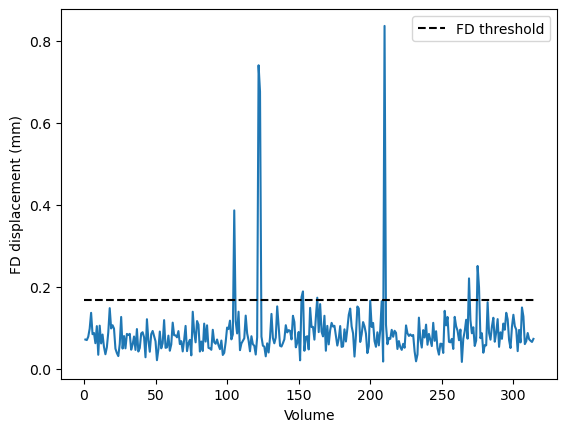

[105 122 123 152 153 163 210 269 275 276]


In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

def inspect_motion_correction(path):
    """
    Function to visualise how much each volume have to be motion-corrected.
    """
    
    #extract parameters
    parameters =pd.read_csv(path, sep='  ', header=None, engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])
    display(parameters)

    #calculate frame-wise displacement
    framewise_diff = parameters.diff().iloc[1:]
    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]

    # Estimating displacement on a 50mm radius sphere
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1).to_numpy()

    #threshold
    threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

    #plot for each volume
    plt.plot(list(range(1, fd.size+1)), fd)
    plt.xlabel('Volume')
    plt.ylabel('FD displacement (mm)')
    plt.hlines(threshold, 0, len(parameters),colors='black', linestyles='dashed', label='FD threshold')
    plt.legend()
    plt.show()

    print(np.where(fd > threshold)[0] + 1)

path_moco_param = os.path.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold_moco.par'.format(subjectID))
inspect_motion_correction(path_moco_param)

We have some volume with high motion. However, we have to take into account that there is 3 run in the data. From precedent analysis, we have 105 scan per run. 
We thus expect high motion around run 105 and 210 !

However, we have a big motion artefact around volume 122 and 3 small ones around volumes 152, 269 and 275. We will have to explore further.

At volume 122 there is a field map artefact.

In [22]:
#EPI coregistration
whole_t1 = anatomical_path
skull_stripped_t1 = betted_brain_path
output_path = op.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold_bbr'.format(subjectID))

ref_vol_name =  op.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold_moco_vol_middle'.format(subjectID))

fslroi(path_moco_data , ref_vol_name, str(52), str(1))

use_single_vol = True

white_matter_segmentation = op.join(preproc_root, subject, 'anat', 'sub-{}_T1w_fast_pve_2.nii.gz'.format(subjectID)) # We provide the white matter segmentation

if RERUN :
    subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), 
                '--out={}'.format(output_path),
               '--wmseg={}'.format(white_matter_segmentation)])

<Figure size 640x480 with 0 Axes>

In [23]:
#fsleyesDisplay.resetOverlays()
#fsleyesDisplay.load(skull_stripped_t1)
#fsleyesDisplay.load(output_path)


(ipykernel_launcher.py:8241): Gdk-WARNING **: 16:52:14.242: gdkdrawable-x11.c:952 drawable is not a pixmap or window


In [26]:
#smoothing
smoothed_path = op.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold_bbr_smoothed-6mm'.format(subjectID))

if RERUN:
    cmd = 'fslmaths {} -s {} {}'.format(output_path, 6/2.3548, smoothed_path)
    subprocess.run(['fslmaths',output_path, '-s', str(6/2.3548), smoothed_path])

In [27]:
#fsleyesDisplay.resetOverlays()
#fsleyesDisplay.load(smoothed_path)

### Experimental design matrix

In [ ]:
#for one run
run_1 = os.path.join(bids_root, subject, 'func', 'sub-{}_task-music_run-1_events.tsv'.format(subjectID))
pd.read_csv(run_1,sep = '\t')

In [28]:
#for all runs 

func_dir = op.join(bids_root, subject, 'func')
pattern = re.compile(r'^sub-control01_task-music_run-\d+_events\.tsv$')
#pattern = re.compile(r'^sub-control01_task-music_run-2_events\.tsv$')

file_paths = []

# Check if the directory exists
if os.path.exists(func_dir):
    for file_name in os.listdir(func_dir):
        # If the file name matches the pattern, add it to the array with the full path
        if pattern.match(file_name):
            full_path = os.path.join(func_dir, file_name)
            file_paths.append(full_path)
file_paths.sort()
# Output the array of all runs
print(len(file_paths))
print(file_paths)

events = pd.DataFrame()
for file in file_paths:
    new_event = pd.read_csv(file,sep = '\t')
    if len(events) > 0 :
        last_onset = events.iloc[-1].onset
        new_event['onset'] += last_onset
    events = pd.concat([events, new_event], ignore_index=True)
events

3
['/data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-1_events.tsv', '/data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-2_events.tsv', '/data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-3_events.tsv']


,onset,duration,trial_type
0,0.0,33.0,tones
1,33.0,3.0,response
2,36.0,31.5,negative_music
3,67.5,3.0,response
4,70.5,31.5,tones
5,102.0,3.0,response
6,105.0,31.5,positive_music
7,136.5,3.0,response
8,139.5,31.5,tones
9,171.0,3.0,response


In [43]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel


# Specify the GLM
# according to task-music_bold.json, the TR is 3 sec
fmri_glm = FirstLevelModel(t_r=3.0,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

# Fit the model to our design and data
dpath = os.path.join(preproc_root, subject, 'func', 'sub-{}_all_task_bold_moco.nii.gz'.format(subjectID))
#dpath  = '/data/dataset/ds000171/sub-control01/func/sub-control01_task-music_run-2_bold.nii.gz'
fmri_glm = fmri_glm.fit(dpath, events)

<Axes: label='conditions', ylabel='scan number'>

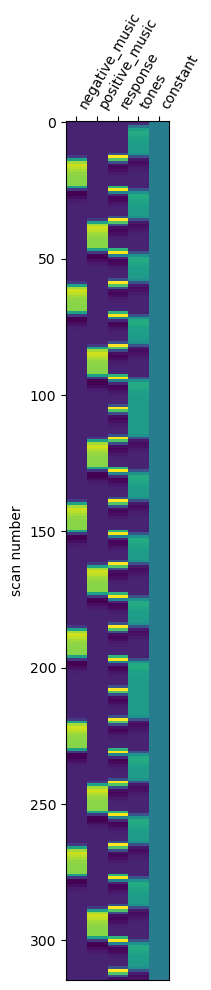

In [44]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0])

### GLM : condition and contrast

In [45]:
# Create the dictionary of the conditions

conditions = {
    'neg_music': np.array([1, 0, 0, 0, 0]), 
    'pos_music':np.array([0, 1, 0, 0, 0]),
    'response':np.array([0, 0, 1, 0, 0]),
    'tones':np.array([0, 0, 0, 1, 0]),
}

pos_neg_contrast = conditions['pos_music'] - conditions['neg_music']

<Axes: label='conditions'>

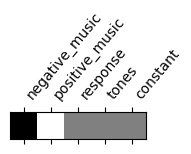

In [46]:
from nilearn.plotting import plot_contrast_matrix
plot_contrast_matrix(pos_neg_contrast, design_matrix=fmri_glm.design_matrices_[0])

/opt/conda/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:308: UserWarning: empty mask
  ims = self._map_show(img, type="imshow", threshold=threshold, **kwargs)


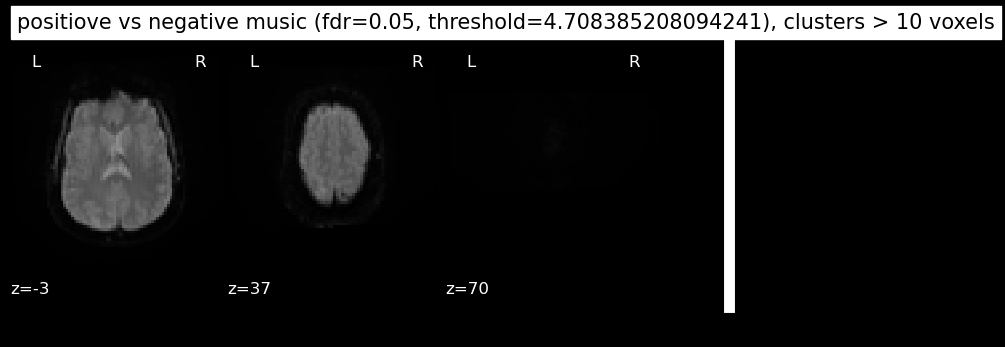

In [47]:
import nibabel as nib
from nilearn.glm import threshold_stats_img
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img

z_map = fmri_glm.compute_contrast(pos_neg_contrast,
                                  output_type='z_score')

nib.save(z_map, 'z_map_uncorrected.nii.gz')

cluster_size = 10 
fdr_rate = 0.05 

# Here, we apply the FDR correction + threshold
clean_map, threshold = threshold_stats_img(z_map, alpha=fdr_rate, height_control='fdr', cluster_threshold=cluster_size)

# And this is just to plot here!
mean_img_ = mean_img(dpath),
plot_stat_map(clean_map, bg_img=mean_img_[0], threshold=threshold,
              display_mode='z', cut_coords=[-3,37,70], black_bg=True,
              title='positiove vs negative music (fdr={}, threshold={}), clusters > {} voxels'.format(fdr_rate, threshold, cluster_size))


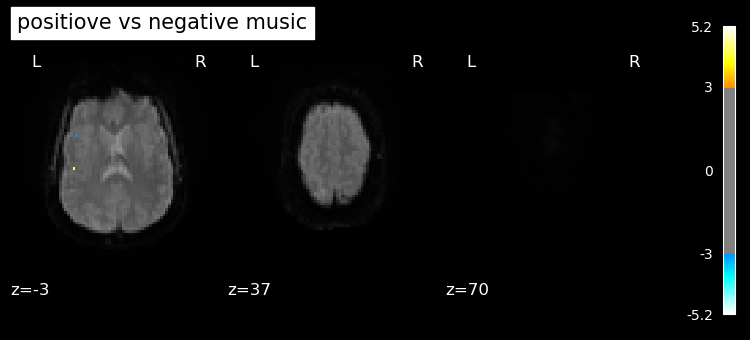

In [48]:

mean_img_ = mean_img(dpath),
plot_stat_map(z_map, bg_img=mean_img_[0], threshold=3.0,
              display_mode='z', cut_coords=[-3,37,70], black_bg=True,
              title='positiove vs negative music')

### Analyse GML result 